In [1]:
# Need to install following required packages to avoid any error
# pip install statsmodels
# pip install patsy
# pip install Tensorflow
# pip install keras

In [2]:
# =======Importing the libraries=======

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import Imputer,LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

from sklearn.decomposition import PCA
import statsmodels.formula.api as sm

from matplotlib.colors import ListedColormap
from pandas.plotting import scatter_matrix


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [3]:
# =======Useful functions=======

def simplifyQTY(data):
    temp = data.replace('M3','').rstrip()
    temp = temp.replace('m3','').rstrip()
    return float(temp)

def normalizeConcSRC(data):
    if "ACC" in data:
        return "ACC"
    else:
        return data
    
def categoriesStrength(row):
    
    if 0 <= row['Comp. Strength in %'] < 100:
        return 0
    
    if 100 <= row['Comp. Strength in %']:
        return 1
    
def removeUnderscore(data):
    temp = data.replace('-','').rstrip()
    return temp

In [4]:
# =======Importing the dataset=======
dataset = pd.read_csv('cube.csv')

In [5]:
# =======Data Preporcessing==========

# removing last row as it contains Na in every col
dataset.drop(dataset.index[len(dataset)-1], inplace=True)    

# removing the metric unit and converting data into float
dataset['Qty.'] = dataset['Qty.'].apply(simplifyQTY)

# uniforming the data, for eg: T5 and T-5 are smiliar but different format, 
dataset['Concrete Grade'] = dataset['Concrete Grade'].apply(removeUnderscore)

dataset['Concrete Source'] = dataset['Concrete Source'].apply(normalizeConcSRC)

# making ranges(>100 & <100) from numeric data
dataset['category'] = dataset.apply (lambda row: categoriesStrength (row),axis=1)    

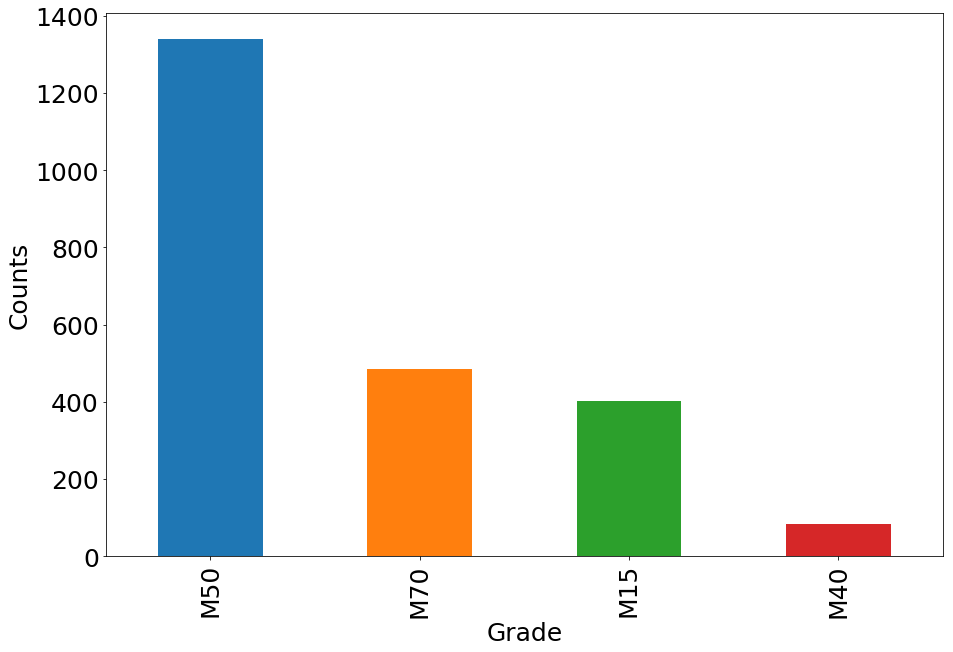

In [6]:
# ================================================ Data Exploration ======================================================

# Concrete grade feature
dataset['Concrete Grade'].value_counts().plot(kind='bar',figsize=(15,10),fontsize = 25)
plt.xlabel('Grade', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.show()


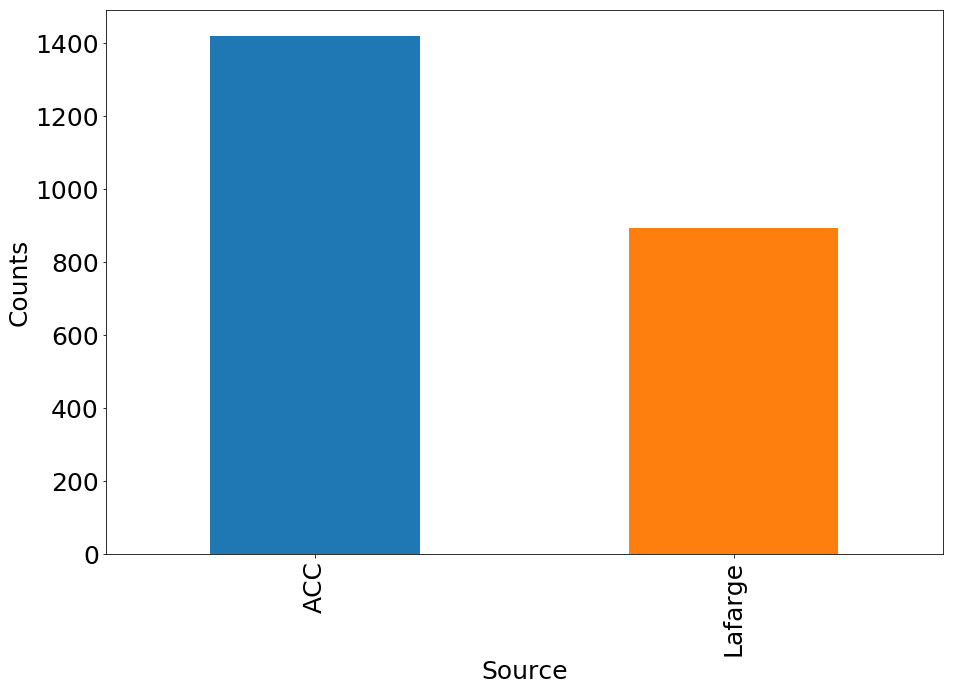

In [7]:
# Concrete Source feature
dataset['Concrete Source'].value_counts().plot(kind='bar',figsize=(15,10),fontsize = 25)
plt.xlabel('Source', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.show()

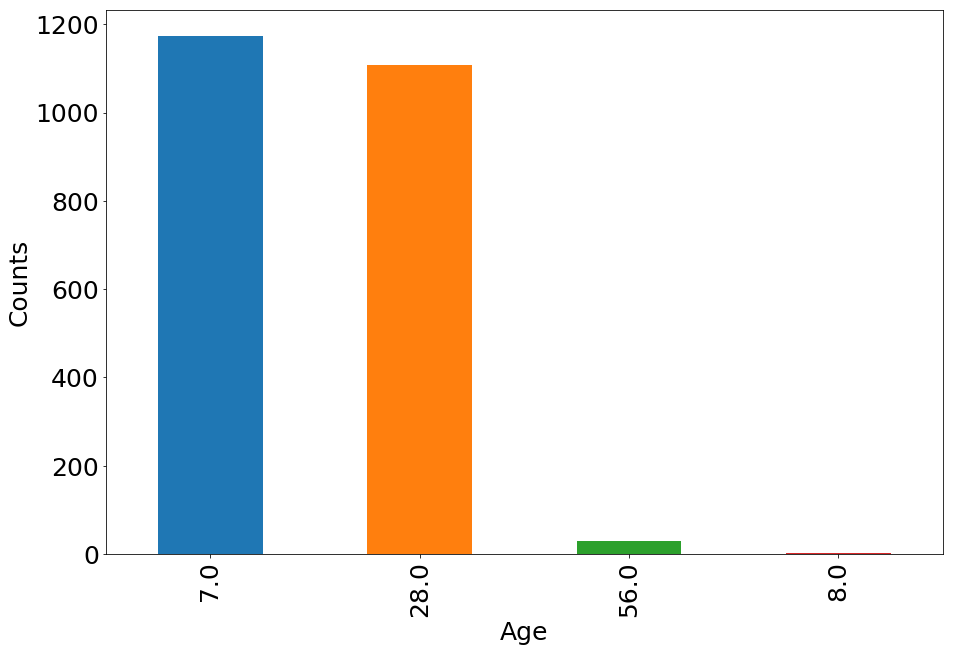

In [8]:
# Age feature
dataset['Age'].value_counts().plot(kind='bar',figsize=(15,10),fontsize = 25)
plt.xlabel('Age', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.show()

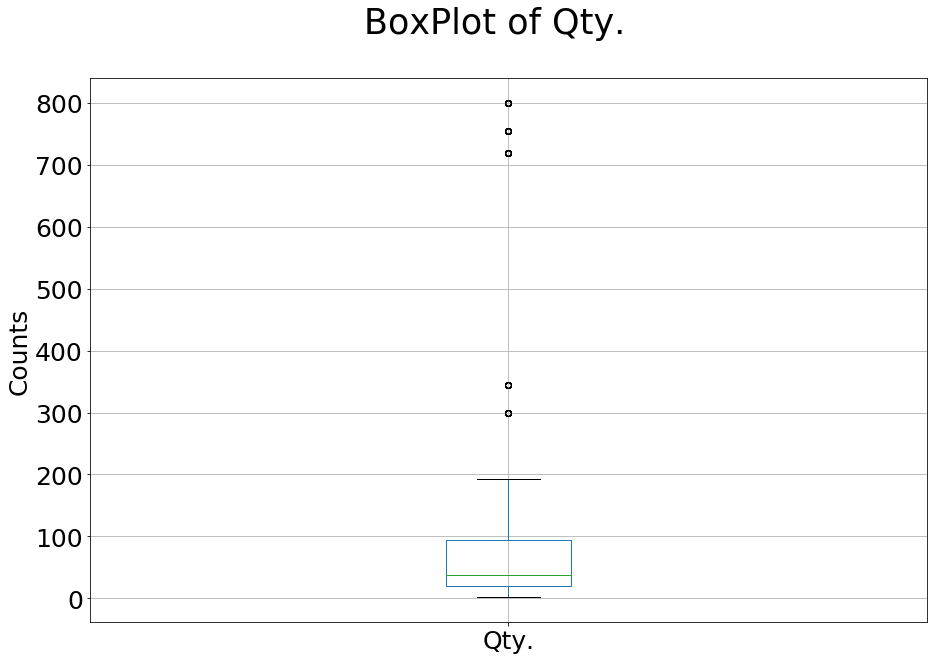

In [9]:
# Qty. Boxplot
dataset.boxplot(column="Qty.",figsize=(15,10),fontsize=25)
plt.suptitle("BoxPlot of Qty.", fontsize=35)
plt.ylabel('Counts', fontsize=25)
plt.show()

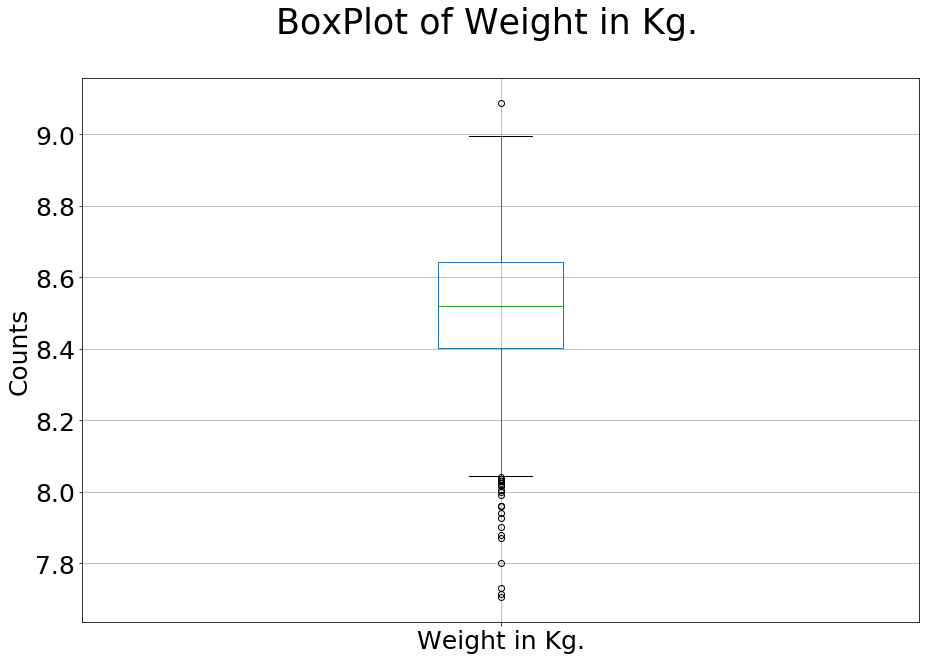

In [10]:
# Weight in Kg. Boxplot
dataset.boxplot(column="Weight in Kg.",figsize=(15,10),fontsize=25)
plt.suptitle("BoxPlot of Weight in Kg.", fontsize=35)
plt.ylabel('Counts', fontsize=25)
plt.show()

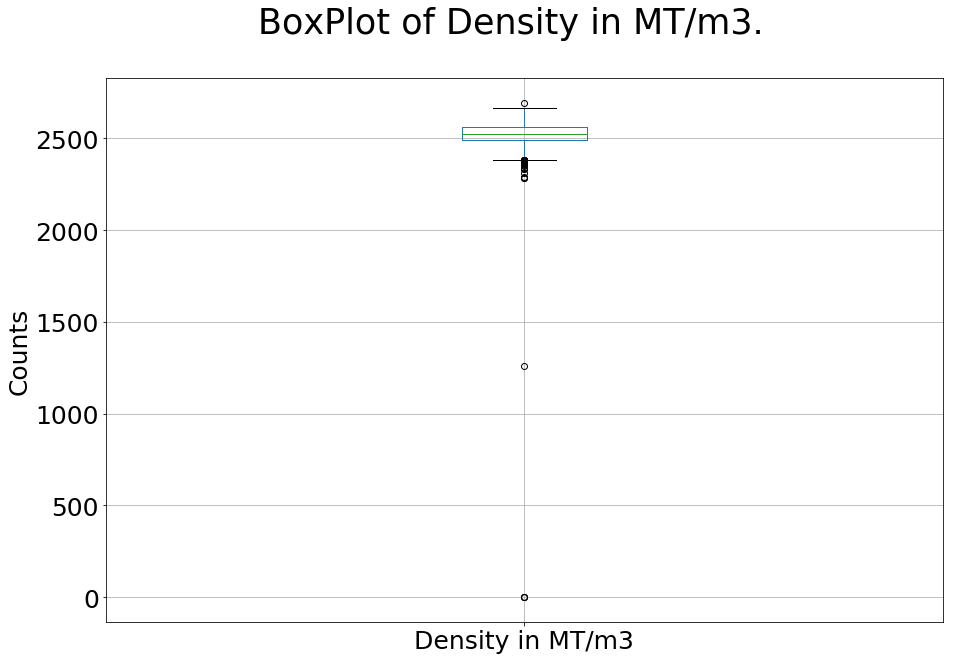

In [11]:
# Density in MT/m3 Boxplot
dataset.boxplot(column="Density in MT/m3",figsize=(15,10),fontsize=25)
plt.suptitle("BoxPlot of Density in MT/m3.", fontsize=35)
plt.ylabel('Counts', fontsize=25)
plt.show()

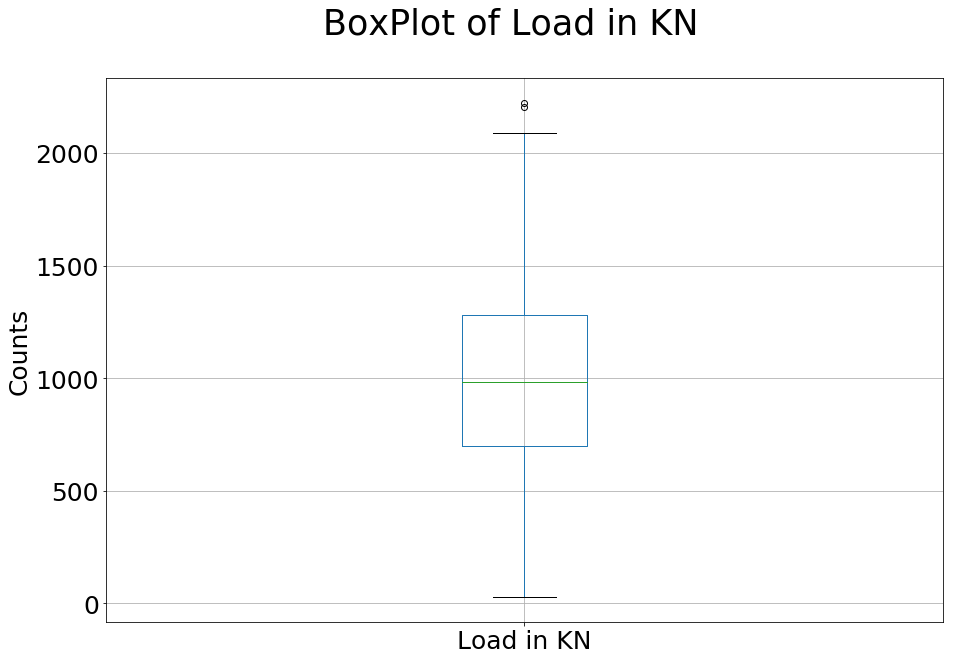

In [12]:
# Load in KN Boxplot
dataset.boxplot(column="Load in KN",figsize=(15,10),fontsize=25)
plt.suptitle("BoxPlot of Load in KN", fontsize=35)
plt.ylabel('Counts', fontsize=25)
plt.show()

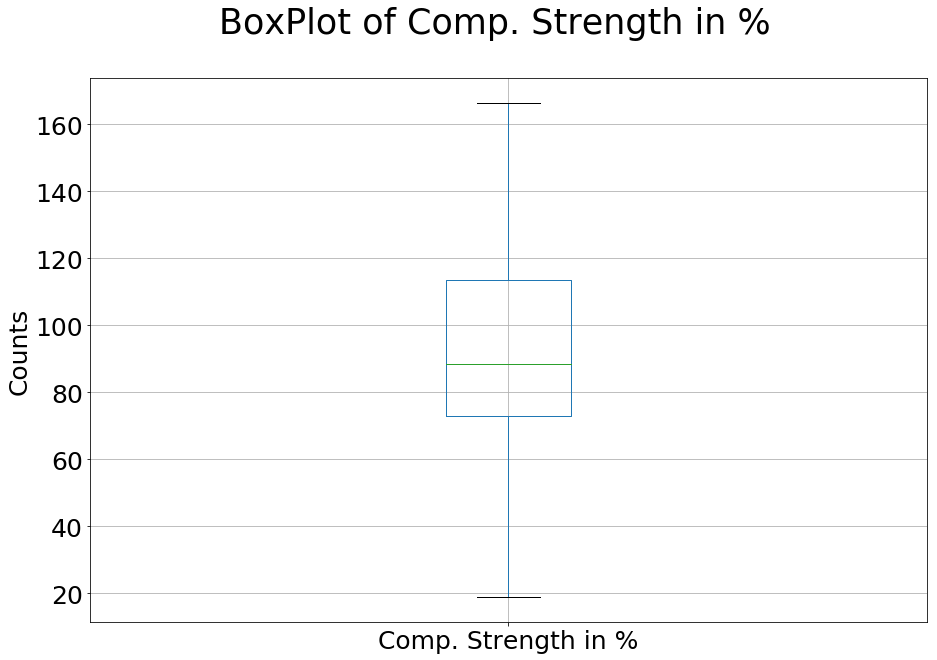

In [13]:
# Comp. Strength in % Boxplot
dataset.boxplot(column="Comp. Strength in %",figsize=(15,10),fontsize=25)
plt.suptitle("BoxPlot of Comp. Strength in %", fontsize=35)
plt.ylabel('Counts', fontsize=25)
plt.show()

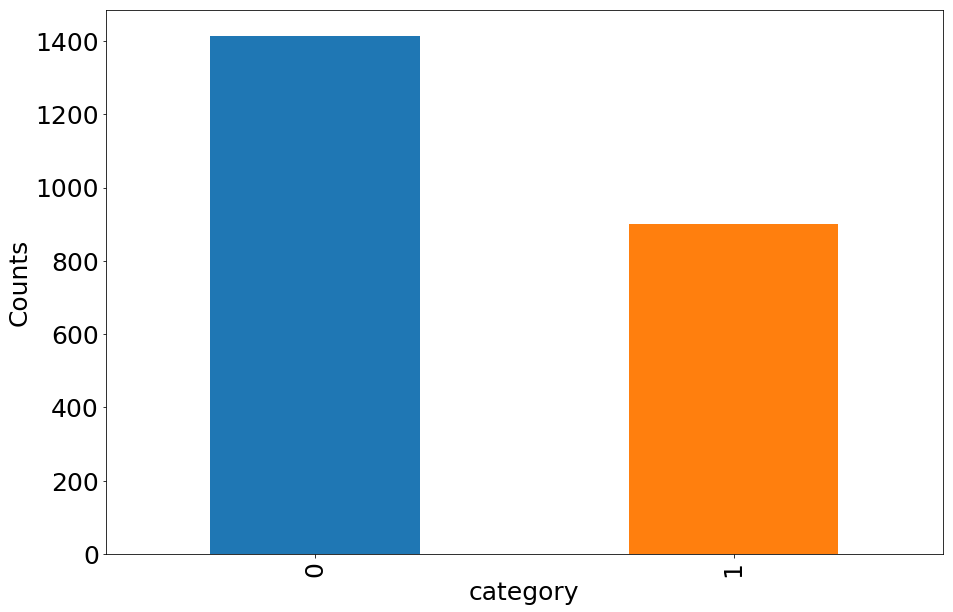

In [14]:
# category grade feature
dataset['category'].value_counts().plot(kind='bar',figsize=(15,10),fontsize = 25)
plt.xlabel('category', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.show()

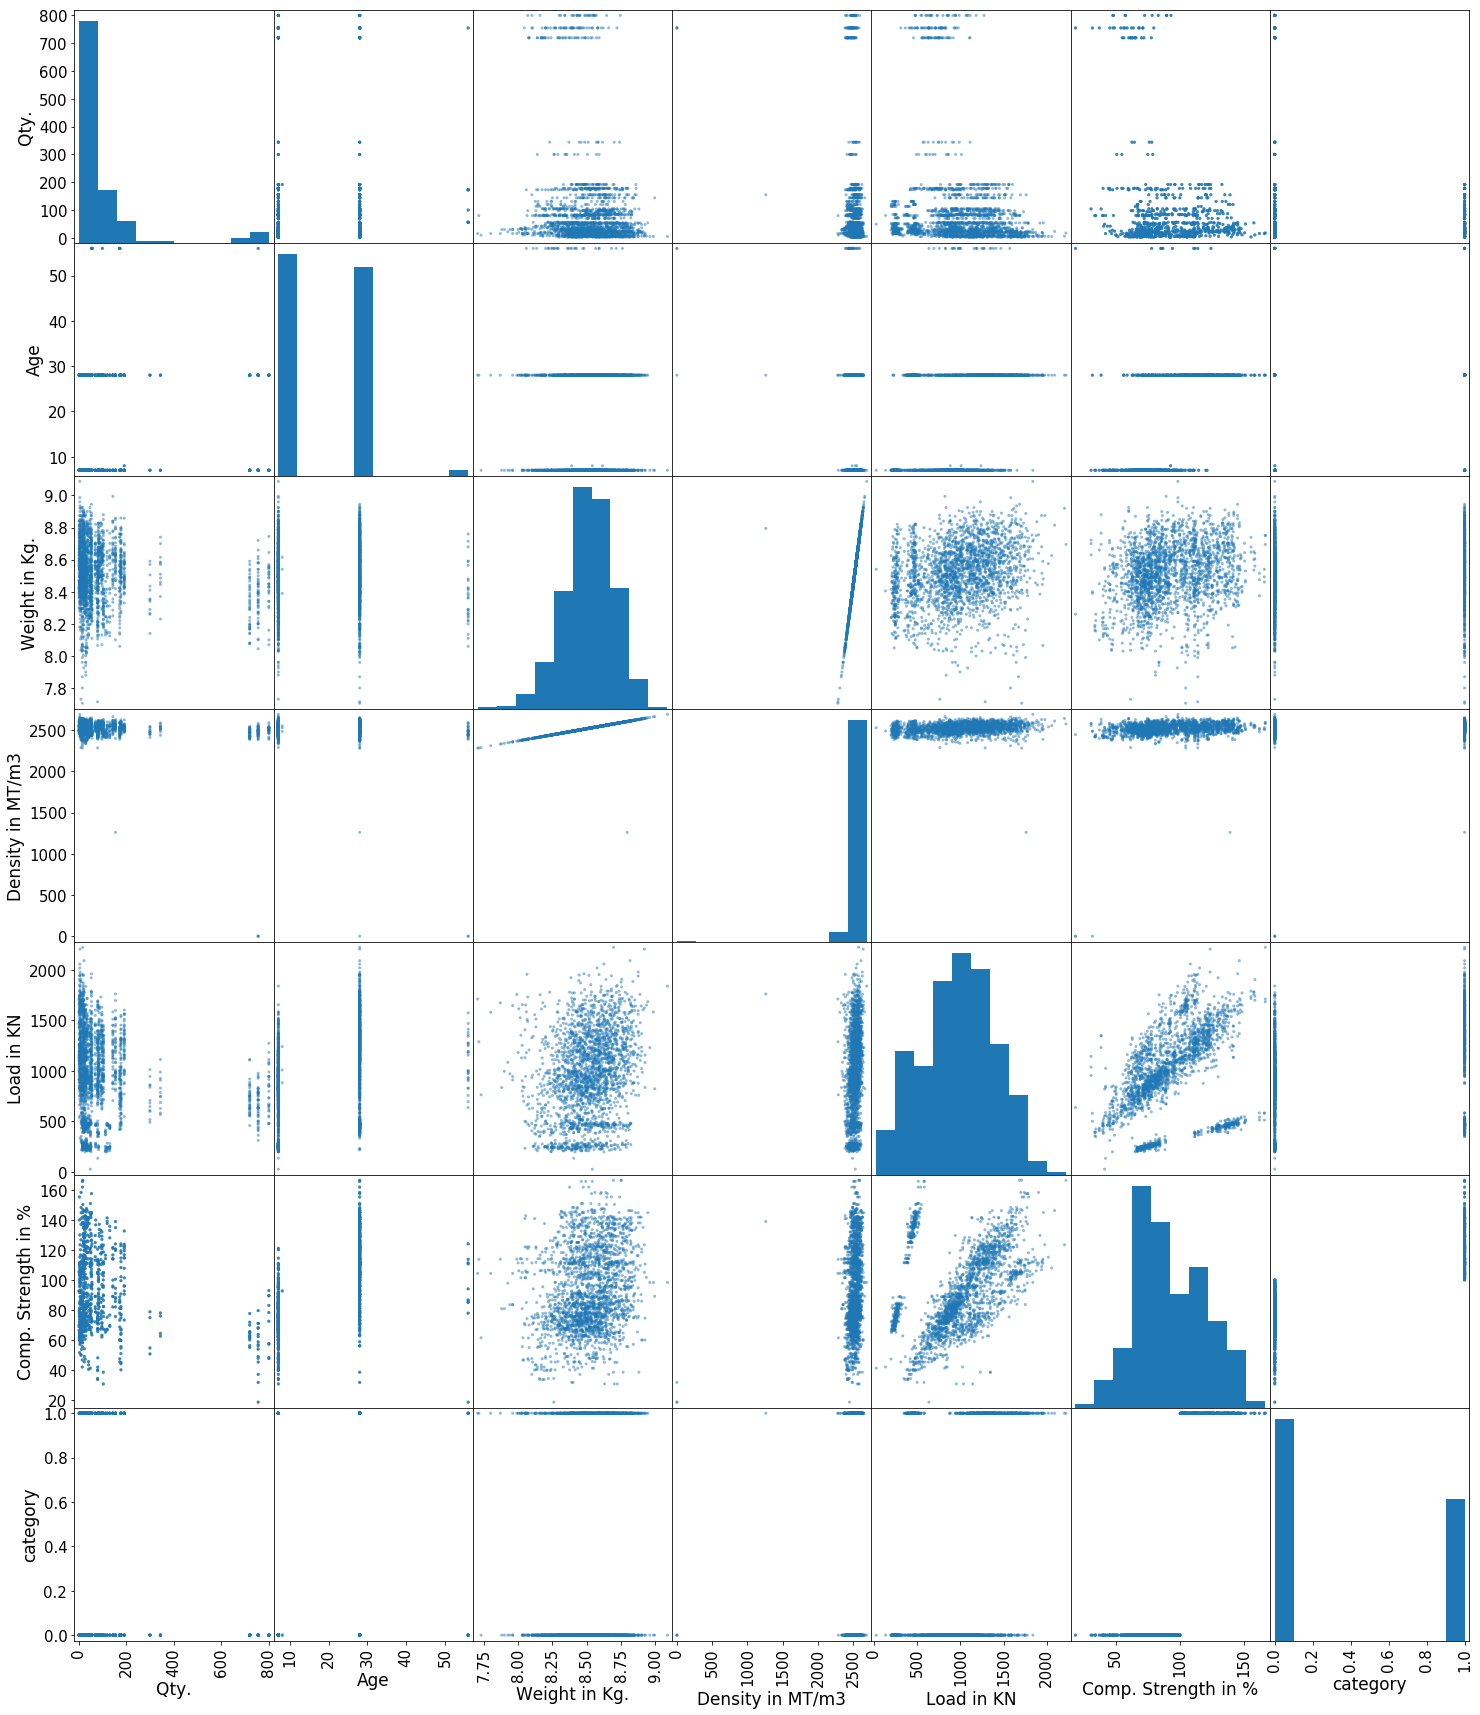

In [15]:
Axes = scatter_matrix(dataset[['Concrete Grade', 'Concrete Source', 'Qty.', 'Age', 'Weight in Kg.',
       'Density in MT/m3', 'Load in KN', 'Comp. Strength in %', 'category']],figsize=(25,30))

[plt.setp(item.yaxis.get_majorticklabels(), 'size', 15) for item in Axes.ravel()]
#x ticklabels
[plt.setp(item.xaxis.get_majorticklabels(), 'size', 15) for item in Axes.ravel()]
#y labels
[plt.setp(item.yaxis.get_label(), 'size', 17) for item in Axes.ravel()]
#x labels
[plt.setp(item.xaxis.get_label(), 'size', 17) for item in Axes.ravel()]

plt.show()

In [16]:
# Sperating dependent and independent variable in X and y respectively
X = dataset.iloc[:, :-2].values
y = dataset.iloc[:, -1].values

In [17]:
# taking care of missing data
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, [2,4,5,6]])
X[:, [2,4,5,6]] = imputer.transform(X[:, [2,4,5,6]])

In [18]:
# hot encoding of categorical  variable
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
X[:, 3] = labelencoder_X.fit_transform(X[:, 3])
onehotencoder = OneHotEncoder(categorical_features = [0,1,3])
X = onehotencoder.fit_transform(X).toarray()

In [19]:
# to avoid dummy trap
X = np.delete(X, 0, 1) 
X = np.delete(X, 3, 1)
X = np.delete(X, 4, 1)

In [20]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
# ================================================ Data Modelling: Model 1 ======================================================

# Fitting Logistic Regression to the Training set
classifierLR = LogisticRegression(random_state = 0)
classifierLR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
y_pred_LR = classifierLR.predict(X_test)

# Making the Confusion Matrix
print("Confusion Matrix \n",confusion_matrix(y_test, y_pred_LR))

Confusion Matrix 
 [[266  13]
 [ 13 171]]


In [24]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierLR, X = X_train, y = y_train, cv = 10)
print("Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_LR), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_LR), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_LR), 2)))

Accuracy: 93.78%
Accuracy STD: 1.86%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93


In [25]:
# Applying Grid Search to find the best model and the best parameters
parameters = [{'C': [1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = classifierLR,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search result: Best Score = {}% Best Param = {}".format(round(grid_search.best_score_*100, 2),grid_search.best_params_))

Grid Search result: Best Score = 93.84% Best Param = {'C': 10}


In [26]:
# Grid search suggests that if we take C=10 
# we can further increase the accuracy but just by a fraction only i.e from 93.78% to 93.83%
# So we will not make any more effort to make new model with above params and this is our final model.

In [27]:
# We can go further with dimensionality reduction to see if there is any scope of improvement.
# Intitution behind taking dimensionality in consideration is that not all feature help in getting good result sometimes, 
# so we will check if its possible to improve model by reducing the dimensionalty to 2

# ===========Applying PCA=================
pca = PCA(n_components = 2)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# Fitting Logistic Regression to the Training set
classifierLR_PCA = LogisticRegression(random_state = 0)
classifierLR_PCA.fit(X_train_PCA, y_train)

# Predicting the Test set results
y_pred_PCA = classifierLR_PCA.predict(X_test_PCA)

# Making the Confusion Matrix
print("Confusion Matrix \n",confusion_matrix(y_test, y_pred_PCA))

Confusion Matrix 
 [[237  42]
 [ 82 102]]


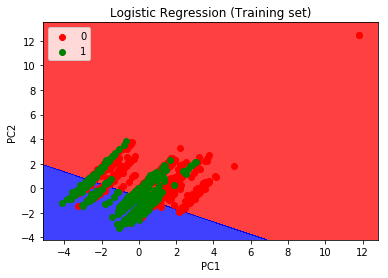

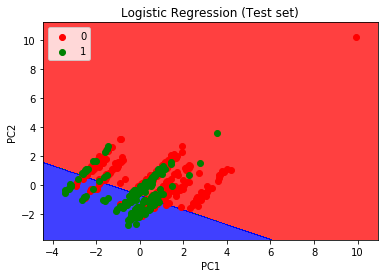

In [28]:
# As we have got dimensionality reduced to 2, that will be easy to visualize the data and prediction boundaries, 
# and also check if data is linearly seperable or not

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train_PCA, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifierLR_PCA.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test_PCA, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifierLR_PCA.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [29]:
# Actually, it has given worse accuracy, that means all feature are important in taking desicion in this particular case of ours
# So instead of reducing all the features to 2 abrubtly, we will implement Backward elimination method. 
# Intuition behind BE is that to check significance level of each feature, and decide whether to take that feature in modeling or not
# In other words, will that feature actually contribute in making decision or just making it worse
# Initially we set a SL, lets say 0.05 then we check p value of all feature, select the highest p value and if its greater than SL
    # we will drop that feature
    # will demonstrate one run below

X_opt = X[:, 0:9]
regressor_OLS = sm.OLS(y, X_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     758.3
Date:                Sun, 20 May 2018   Prob (F-statistic):               0.00
Time:                        18:17:33   Log-Likelihood:                -598.15
No. Observations:                2313   AIC:                             1214.
Df Residuals:                    2304   BIC:                             1266.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1863      0.040     -4.676      0.000      -0.264      -0.108
x2            -0.0640      0.020     -3.253      0.001      -0.103      -0.025
x3            -0.2510      0.025    -10.245      0.000      -0.299      -0.203
x4             0.0703      0.016      4.340      0.000       0.039       0.102
x5             0.0080      0.182      0.044      0.965      -0.348       0.364
x6             0.7077      0.013     53.661      0.000       0.682       0.734
x7             0.4016      0.059      6.853      0.000       0.287       0.517
x8            -0.0006   4.35e-05    -13.918      0.000      -0.001      -0.001
x9             0.0202      0.002     10.025      0.000       0.016       0.024
==============================================================================
Omnibus:                      142.049   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.732
Skew:                          -0.353   Prob(JB):                     4.19e-77
Kurtosis:                       4.775   Cond. No.                     5.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# As we can see that the p value of x5 variable is highest and greater than SL, we will drop it 
# and repeat the process untill we get all p values less than SL
# it will be a long process to do it step by step manually, so below is the code for automation of backward elimination

In [31]:
# ============Backward elimination===============
import statsmodels.formula.api as sm
def backwardElimination(x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x
 
SL = 0.05
X_opt = X[:, 0:11]
X_Modeled = backwardElimination(X_opt, SL)

print("Number of features left after backward elimination: {}".format(len(X_Modeled[0])))

Number of features left after backward elimination: 8


In [32]:
# Its hard to detect which categorical feature got drop but we can see that only QTY and Load in KN have been left
print(X_Modeled[0,:],"\n",X[0,:])

[   0.     0.     0.     0.     0.     0.    84.   243.5] 
 [    0.             0.             0.             0.             0.             0.
     0.            84.             8.73        2586.66666667   243.5       ]


In [33]:
# So this method reduced number of features to 8, lets try to fit the model on new set of independent variables i.e X_Modeled

# train and test split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_Modeled, y, test_size = 0.2, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train_reduced = sc.fit_transform(X_train_reduced)
X_test_reduced = sc.transform(X_test_reduced)

# Fitting Logistic Regression to the Training set
classifier_reduced = LogisticRegression(random_state = 0)
classifier_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_reduced = classifier_reduced.predict(X_test_reduced)

# Making the Confusion Matrix
print("Confusion Matrix \n",confusion_matrix(y_test_reduced, y_pred_reduced))

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifier_reduced, X = X_train_reduced, y = y_train_reduced, cv = 10)
print("Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))

Confusion Matrix 
 [[266  13]
 [ 14 170]]
Accuracy: 93.73%
Accuracy STD: 1.97%


In [34]:
# Backward Elimination also didnt helo to improve performance. We are still at 93.73% accuracy

In [35]:
# ================================================ Data Modelling: Model 2 ======================================================
# As we have selected a linear model before, lets try with non linear model, eg: Kernel SVM(Gaussian)
# data has been imported and cleaned aready. we will start with modelling straightly

# Fitting Kernel SVM to the Training set
classifierSVM = SVC(kernel = 'rbf', random_state = 0)
classifierSVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
# Predicting the Test set results
y_pred_SVM = classifierSVM.predict(X_test)

# Making the Confusion Matrix
print("Confusion Matrix \n",confusion_matrix(y_test, y_pred_SVM))

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierSVM, X = X_train, y = y_train, cv = 10)
print("Final Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Final Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_SVM), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_SVM), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_SVM), 2)))

Confusion Matrix 
 [[264  15]
 [ 16 168]]
Final Accuracy: 93.57%
Final Accuracy STD: 2.48%
Precision: 0.92
Recall: 0.91
F1 Score: 0.92


In [37]:
# Applying Grid Search to find the best model and the best parameters
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifierSVM,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Grid Search result: Best Score = {}% Best Param = {}".format(round(grid_search.best_score_*100, 2),grid_search.best_params_))

Grid Search result: Best Score = 94.0% Best Param = {'gamma': 0.1, 'kernel': 'rbf', 'C': 100}


In [38]:
# Grid search suggests that if we take 'C': 100, 'gamma': 0.1 
# we can further increase the accuracy but just by a fraction only i.e from 93.57% to 94%
# So we will not make any more effort to make new model with above params and this is our final model.

In [39]:
# ================================================ Data Modelling: Model 3 ======================================================

# Fitting Random Forest Classification to the Training set
classifierRM = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierRM.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
# Predicting the Test set results
y_pred_RM = classifierRM.predict(X_test)

# Making the Confusion Matrix
print("Confusion Matrix \n",confusion_matrix(y_test, y_pred_RM))

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifierRM, X = X_train, y = y_train, cv = 10)
print("Final Accuracy: {}%".format(round(accuracies.mean()*100, 2))) 
print("Final Accuracy STD: {}%".format(round(accuracies.std()*100, 2)))
print("Precision: {}".format(round(precision_score(y_test, y_pred_RM), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_RM), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_RM), 2)))

Confusion Matrix 
 [[271   8]
 [ 16 168]]
Final Accuracy: 94.0%
Final Accuracy STD: 1.41%
Precision: 0.95
Recall: 0.91
F1 Score: 0.93


In [41]:
# Applying Grid Search to find the best model and the best parameters
parameters = [{'n_estimators': [1, 10, 100, 1000], 'criterion': ['entropy']},
              {'n_estimators': [1, 10, 100, 1000], 'criterion': ['gini']}]
grid_search = GridSearchCV(estimator = classifierRM,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Grid Search result: Best Score = {}% Best Param = {}".format(round(grid_search.best_score_*100, 2),grid_search.best_params_))

Grid Search result: Best Score = 94.86% Best Param = {'criterion': 'gini', 'n_estimators': 100}


In [42]:
# Grid search suggests that if we take 'criterion': 'gini', 'n_estimators': 100
# we can further increase the accuracy but just by a fraction only i.e from 94% to 94.86%
# So we will not make any more effort to make new model with above params and this is our final model.

In [56]:
# ================================================ Data Modelling: Model 4 ======================================================

# Now we will try deep learning models, lets start with simple sequential Artificial Neural Network 
# with just 2 dense hidden layers with 6 nodes in each. Dense means that output of every node is input to every node in next layer
# Relu function has been used in hidden layer, as proven to be the best activation function so far
# And Sigmoid function in last layer to find probabilities of each class
# epochs have been choosen randomly to 50 which we think is optimal for this data, we will further see details in accuracy and loss graph below
# and lastly if the output probability is greater than 0.5 then we classify it th strength >100% and vice versa
# this model has also performed very well with 93.81% accuracy which is very close to above models

classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(activation="relu", input_dim=len(X_train[0]), units=6, kernel_initializer="uniform"))

# Adding the second hidden layer
classifier.add(Dense(activation="relu", units=6, kernel_initializer="uniform"))

# Adding the output layer
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 50)



Epoch 1/50
1850/1850 [==============================] - 0s - loss: 0.6630 - acc: 0.6459     
Epoch 2/50
1850/1850 [==============================] - 0s - loss: 0.4222 - acc: 0.8978     
Epoch 3/50
1850/1850 [==============================] - 0s - loss: 0.2850 - acc: 0.8924     
Epoch 4/50
1850/1850 [==============================] - 0s - loss: 0.2514 - acc: 0.9027     
Epoch 5/50
1850/1850 [==============================] - 0s - loss: 0.2351 - acc: 0.9114     
Epoch 6/50
1850/1850 [==============================] - 0s - loss: 0.2225 - acc: 0.9178     
Epoch 7/50
1850/1850 [==============================] - 0s - loss: 0.2119 - acc: 0.9200     
Epoch 8/50
1850/1850 [==============================] - 0s - loss: 0.2036 - acc: 0.9276     
Epoch 9/50
1850/1850 [==============================] - 0s - loss: 0.1958 - acc: 0.9281     
Epoch 10/50
1850/1850 [==============================] - 0s - loss: 0.1892 - acc: 0.9335     
Epoch 11/50
1850/1850 [==============================] - 0s - loss: 0

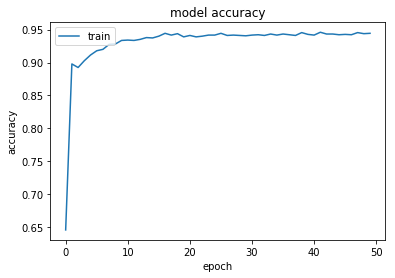

In [58]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

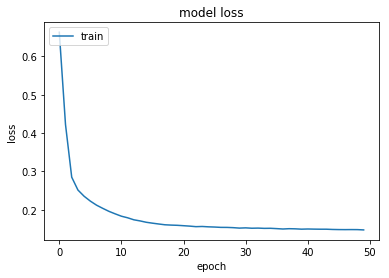

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# as we can see the accuracy and loss are exactly compliment of each other

In [44]:
#Making the predictions and evaluating the model

# Predicting the Test set results
y_pred_ann = classifier.predict(X_test)
y_pred_ann = (y_pred_ann > 0.5)

cm_ann = confusion_matrix(y_test, y_pred_ann)

In [45]:
# Making the Confusion Matrix
print("Confusion Matrix \n",cm_ann)

print("Accuracy: %.2f%%" % ((1 - (cm_ann[0,1]+cm_ann[1,0])/(cm_ann[0,0]+cm_ann[1,1]))*100))
print("Precision: {}".format(round(precision_score(y_test, y_pred_ann), 2)))
print("Recall: {}".format(round(recall_score(y_test, y_pred_ann), 2)))
print("F1 Score: {}".format(round(f1_score(y_test, y_pred_ann), 2)))

Confusion Matrix 
 [[264  15]
 [ 12 172]]
Accuracy: 93.81%
Precision: 0.92
Recall: 0.93
F1 Score: 0.93


In [ ]:
# even being so powerful and flexible tool, it has not crossed RandomForest in terms of accuracy for this dataset

In [61]:
# ================================================ Data Modelling: Experimentation with CNN ======================================================

# Here we are gonna take a further deep delve in deep learning methods, we will create the images out of the numeric data, 
# those images will be fed into CNN which is advance version of ANN when it come to image classification.
# as we have 11 feature, so we have decide to make 11 * 11 image by replicating one row of data to 11 times to make a 11 * 11 matrix ans eventually image
# this is just an experimentation part, we don't expect any accuracy here. We are just trying a new/innovative/neverDoneBefore
# method of coverting numeric data to images and eventually using CNN for classification.

images_train = []
for j in range(len(X_train)):
    image = []
    for i in range(len(X_train[0])):
        image.append(X_train[0])
    images_train.append(image)
    

images_test = []
for j in range(len(X_test)):
    image = []
    for i in range(len(X_test[0])):
        image.append(X_test[0])
    images_test.append(image)
    
images_train = np.array(images_train)
images_test = np.array(images_test)

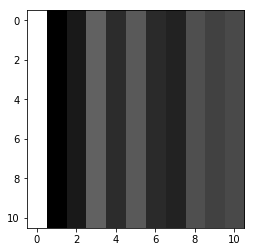

In [66]:
# Before it gets reshaped in next section, 
# it can be run multiple time here to see different images made out of numeric data.

plt.imshow(images_train[np.random.randint(0,len(images_train)-1)], cmap = 'gray')

In [55]:
# images have been conveterd into grayscale images from RGB(3 channels to one channel which is the second argument in reshape function below)
images_train = images_train.reshape(images_train.shape[0], 1, 11, 11)
images_test = images_test.reshape(images_test.shape[0], 1, 11, 11)
    
images_y_train = y_train.reshape(y_train.shape[0],1).astype('float32')
images_y_test = y_test.reshape(y_test.shape[0],1).astype('float32')
num_classes = images_y_test.shape[1]

#All the paramenters have been selected randomly including Number of layers, conv filters and its size, maxpooling, 
# dropout(to avoid overfitting)
model = Sequential()
model.add(Conv2D(30, (3, 3), input_shape=(1, images_train.shape[2], images_train.shape[2]), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(30, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(images_train, images_y_train,  epochs=50, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(images_test, images_y_test, verbose=0)
print("CNN Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/50
1s - loss: 9.7723 - acc: 0.3870
Epoch 2/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 3/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 4/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 5/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 6/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 7/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 8/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 9/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 10/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 11/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 12/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 13/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 14/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 15/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 16/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 17/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 18/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 19/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 20/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 21/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 22/50
0s - loss: 9.7723 - acc: 0.3870
Epoch 23/50
0s - loss: 9.7723 - acc: 0.38

In [ ]:
# As we have claimed before that we can't claim any accuracy with this model

In [47]:
# ============================== Final Comments =====================================

# All model performed well with accuracies around 94%
# we can provide a portal to the company, which can help to predict/or get intuition 
# about how much strength can be acheive by given combinations of features
# before actually building it